# Part 1
In the following cell, modules from standard libraries are imported. We also define several functions for (1) implementing landmark selection techniques (the proposed importance sampling method and related work) and (2) generating low-rank Nystrom approximations. 

In [17]:
from utils import *

# Part 2
In the following cell, we load wine_quality data and compute the original kernel matrix and its best rank-r approximation as a baseline.

In [28]:
# Imbalanced data 
Dataa= fetch_datasets(filter_data =(20,"wine_quality"))
m1 = []
m2 = []

for i , j in Dataa.items():
    m1.append(i)
    m2.append(j)
dataset=m2[0]
X=dataset['data']
y=dataset['target']

# preprocess the data using MinMaxScaler 
min_max_scaler = preprocessing.MinMaxScaler()
X = min_max_scaler.fit_transform(X)

print("size of input data and target: ", X.shape, y.shape)


# find the kernel bandwidth parameter 
beta = 2
DistMatrix = euclidean_distances(X, squared=True) 
sigma = beta * np.sqrt( np.sum(DistMatrix, axis=(0,1))/(len(DistMatrix)**2 - len(DistMatrix)) )

# form the kernel matrix 
K_org = np.exp(-DistMatrix/(sigma**2))
K_org = (K_org + K_org.T)/2
K_org_frob_norm = la.norm(K_org)
EigVec, EigVal, _ = la.svd(K_org)
max_eig = EigVal[0]

# low-rank approximation 
r = 2
EigVec_r = EigVec[:,0:r]
EigVal_r = EigVal[0:r]

# save results for the best rank-r approximation
best_approx_norm = la.norm(K_org - la.multi_dot([EigVec_r,np.diag(EigVal_r),EigVec_r.T]))/K_org_frob_norm
print("Best approximation error: ", best_approx_norm)

size of input data and target:  (4898, 11) (4898,)
Best approximation error:  0.05859442772617733


# Part 3

In the following cell, various landmark selection techniques are compared in terms of accuracy and running time.

In [34]:
m_all = r * np.array([2,5])
n_trial = 50

for index in np.arange(2):
    m = m_all[index]
    print(m)
    globals()["results_error_m" + str(m)] = pd.DataFrame(-1*np.ones((n_trial,5)), columns = ['uniform','kmeans','dpp', 'imp_v1', 'imp_v2']) 
    globals()["results_time_m" + str(m)] = pd.DataFrame(-1*np.ones((n_trial,5)), columns = ['uniform','kmeans','dpp', 'imp_v1', 'imp_v2']) 

    err_uni = -1*np.ones(n_trial)
    err_kmeans = -1*np.ones(n_trial)
    err_dpp = -1*np.ones(n_trial)
    err_imp1 = -1*np.ones(n_trial)
    err_imp2 = -1*np.ones(n_trial)

    time_uni = -1*np.ones(n_trial)
    time_kmeans = -1*np.ones(n_trial)
    time_dpp = -1*np.ones(n_trial)
    time_imp1 = -1*np.ones(n_trial)
    time_imp2 = -1*np.ones(n_trial)


    for exper in np.arange(n_trial):
        #uniform 
        start = time.time()
        Z_uni = landmark_uniform(X, m)
        EigVec_uni, EigVal_uni = nystrom(X, Z_uni, sigma, r)
        time_uni[exper] = time.time() - start
        err_uni[exper] = la.norm(K_org - la.multi_dot([EigVec_uni,np.diag(EigVal_uni),EigVec_uni.T]))/K_org_frob_norm
    
        #kmeans 
        start = time.time()
        Z_kmeans = landmark_kmeans(X, m)
        EigVec_kmeans, EigVal_kmeans = nystrom(X, Z_kmeans, sigma, r)
        time_kmeans[exper] = time.time() - start
        err_kmeans[exper] = la.norm(K_org - la.multi_dot([EigVec_kmeans,np.diag(EigVal_kmeans),EigVec_kmeans.T]))/K_org_frob_norm
    
        #dpp
        start = time.time()
        Z_dpp = landmark_dpp(K_org,X,max_eig,m)
        if la.norm(Z_dpp - np.ones((m,X.shape[1]))) != 0:
            EigVec_dpp, EigVal_dpp = nystrom(X, Z_dpp, sigma, r)
            time_dpp[exper] = time.time() - start
            err_dpp[exper] = la.norm(K_org - la.multi_dot([EigVec_dpp,np.diag(EigVal_dpp),EigVec_dpp.T]))/K_org_frob_norm
    
    
        #imp_v1 (alpha=0.5) 
        start = time.time()
        Z_imp = landmark_importanceSampling(X, sigma, m, frac=0.1, alpha=0.5)
        EigVec_imp, EigVal_imp = nystrom(X, Z_imp, sigma, r)
        time_imp1[exper] = time.time() - start
        err_imp1[exper] = la.norm(K_org - la.multi_dot([EigVec_imp,np.diag(EigVal_imp),EigVec_imp.T]))/K_org_frob_norm
    
        #imp_v2 (alpha=1) 
        start = time.time()
        Z_imp = landmark_importanceSampling(X, sigma, m, frac=0.1, alpha=1)
        EigVec_imp, EigVal_imp = nystrom(X, Z_imp, sigma, r)
        time_imp2[exper] = time.time() - start
        err_imp2[exper] = la.norm(K_org - la.multi_dot([EigVec_imp,np.diag(EigVal_imp),EigVec_imp.T]))/K_org_frob_norm
    
    
    globals()["results_error_m" + str(m)]["uniform"] = err_uni
    globals()["results_error_m" + str(m)]["kmeans"] = err_kmeans
    globals()["results_error_m" + str(m)]["dpp"] = err_dpp
    globals()["results_error_m" + str(m)]["imp_v1"] = err_imp1
    globals()["results_error_m" + str(m)]["imp_v2"] = err_imp2

    globals()["results_time_m" + str(m)]["uniform"] = time_uni
    globals()["results_time_m" + str(m)]["kmeans"] = time_kmeans
    globals()["results_time_m" + str(m)]["dpp"] = time_dpp
    globals()["results_time_m" + str(m)]["imp_v1"] = time_imp1
    globals()["results_time_m" + str(m)]["imp_v2"] = time_imp2

4
L (likelihood) kernel computed via:
- eigendecomposition of K
- eig_L = eig_K/(1-eig_K)
- U diag(eig_L) U.T
L (likelihood) kernel computed via:
- eigendecomposition of K
- eig_L = eig_K/(1-eig_K)
- U diag(eig_L) U.T
L (likelihood) kernel computed via:
- eigendecomposition of K
- eig_L = eig_K/(1-eig_K)
- U diag(eig_L) U.T
L (likelihood) kernel computed via:
- eigendecomposition of K
- eig_L = eig_K/(1-eig_K)
- U diag(eig_L) U.T
L (likelihood) kernel computed via:
- eigendecomposition of K
- eig_L = eig_K/(1-eig_K)
- U diag(eig_L) U.T
L (likelihood) kernel computed via:
- eigendecomposition of K
- eig_L = eig_K/(1-eig_K)
- U diag(eig_L) U.T
L (likelihood) kernel computed via:
- eigendecomposition of K
- eig_L = eig_K/(1-eig_K)
- U diag(eig_L) U.T
L (likelihood) kernel computed via:
- eigendecomposition of K
- eig_L = eig_K/(1-eig_K)
- U diag(eig_L) U.T
L (likelihood) kernel computed via:
- eigendecomposition of K
- eig_L = eig_K/(1-eig_K)
- U diag(eig_L) U.T
L (likelihood) kernel comp

L (likelihood) kernel computed via:
- eigendecomposition of K
- eig_L = eig_K/(1-eig_K)
- U diag(eig_L) U.T
L (likelihood) kernel computed via:
- eigendecomposition of K
- eig_L = eig_K/(1-eig_K)
- U diag(eig_L) U.T
L (likelihood) kernel computed via:
- eigendecomposition of K
- eig_L = eig_K/(1-eig_K)
- U diag(eig_L) U.T
L (likelihood) kernel computed via:
- eigendecomposition of K
- eig_L = eig_K/(1-eig_K)
- U diag(eig_L) U.T
L (likelihood) kernel computed via:
- eigendecomposition of K
- eig_L = eig_K/(1-eig_K)
- U diag(eig_L) U.T
L (likelihood) kernel computed via:
- eigendecomposition of K
- eig_L = eig_K/(1-eig_K)
- U diag(eig_L) U.T
L (likelihood) kernel computed via:
- eigendecomposition of K
- eig_L = eig_K/(1-eig_K)
- U diag(eig_L) U.T
L (likelihood) kernel computed via:
- eigendecomposition of K
- eig_L = eig_K/(1-eig_K)
- U diag(eig_L) U.T
L (likelihood) kernel computed via:
- eigendecomposition of K
- eig_L = eig_K/(1-eig_K)
- U diag(eig_L) U.T
L (likelihood) kernel comput

# Part 4
We plot the approximation quality and running time. 

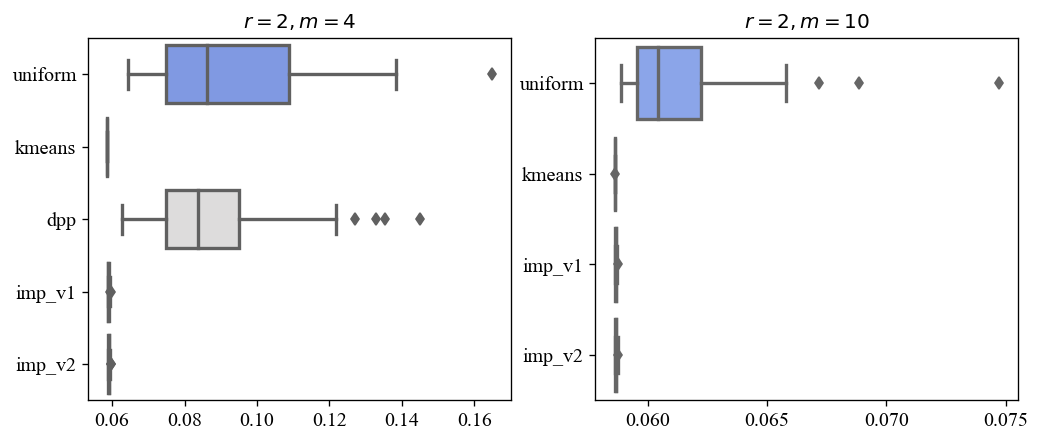

In [35]:
fig, axes = plt.subplots(1, 2, figsize=(10,4))
axes[0].set_title("$r=2, m=4$")
sns.boxplot(data=results_error_m4, orient="h", palette="coolwarm", ax=axes[0])

axes[1].set_title("$r=2, m=10$")
sns.boxplot(data=results_error_m10.loc[:, results_error_m10.columns != 'dpp'], orient="h", palette="coolwarm",ax=axes[1])

In [36]:
results_time_m4.mean(), results_time_m10.mean()

(uniform     0.001501
 kmeans      0.200232
 dpp        22.890214
 imp_v1      0.030099
 imp_v2      0.031554
 dtype: float64, uniform    0.003454
 kmeans     0.418592
 dpp       -1.000000
 imp_v1     0.061216
 imp_v2     0.058198
 dtype: float64)